<a href="https://colab.research.google.com/github/tkreitzberg/Adanalyser/blob/master/ERM_V3_T3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabel of Contents 
*   Setup
*   Preprocessing
*   General Training Code
*   Optimization
*   Evaluation of the model
*   Test of pre-trained Model
*   Cross Validation using K-Fold

Usecase: Emotional Research Model for Task T3
Identify the valence of full body exposure with facial expression

Author: Tim Kreitzberg
Date: 04.06.2021

# Setup
Import dataset and libaries

In [4]:
import tensorflow, os, shutil
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
import random
import skimage.io
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8MB 4.0MB/s 
     |████████████████████████████████| 133kB 30.4MB/s 
     |████████████████████████████████| 174kB 28.7MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=6424f4b5c2f912985273c5677aa24fa45268ff81e2fba6893d662aad48b616bf
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=e7fbb49b18406ed45651df78d502b2b1f2c9c4266bef0fb0cc670f435b4cb2af
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

## Import Dataset
Unzip datasets

In [5]:
!unzip Dataset_T3.zip -d /content/Dataset

Archive:  Dataset_T3.zip
   creating: /content/Dataset/Dataset_T3/0/
  inflating: /content/Dataset/Dataset_T3/0/final1.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final10.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final100.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final101.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final102.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final103.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final104.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final105.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final106.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final107.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final108.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final109.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final11.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final110.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final111.jpg  
  inflating: /content/Dataset/Dataset_T3/0/final112.jpg  
  infla

# Preprosseing



In [ ]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

In [ ]:
# Load training and testing datasets.
data_dir = "/content/Dataset/Dataset_T3"

images, labels = load_data(data_dir)

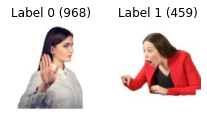

In [ ]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

Normalize and grayscale

In [ ]:
# converting list to array
images_np = np.array(images)

images_grayscale = np.zeros(images_np.shape[:-1])
for i in range(images_np.shape[0]): 
    images_grayscale[i] = cv2.cvtColor(images_np[i], cv2.COLOR_BGR2GRAY)

images_resize = [skimage.transform.resize(image, (244, 244), mode='constant')
            for image in images_grayscale]

# converting list to array
images_v = np.array(images_resize)
images_v = np.expand_dims(images_v, axis=3)

labels_v = np.array(labels)

Split into Train, Validation and Test set

In [ ]:
# Split the into trainset and test
trainset_data, test_data, trainset_label, test_label = train_test_split(images_v, labels_v, test_size=0.1, shuffle= True)

# Split the trainset into train and validation
train_data, validation_data, train_label, validation_label = train_test_split(trainset_data, trainset_label, test_size=0.33, shuffle= True)

print(train_data.shape)
print(train_label.shape)

print(validation_data.shape)
print(validation_label.shape)

print(test_data.shape)
print(test_label.shape)

(860, 244, 244, 1)
(860,)
(424, 244, 244, 1)
(424,)
(143, 244, 244, 1)
(143,)


Save in directory

In [ ]:
#save datasets after creation
os.makedirs("/content/Dataset_processed/Train_Data/0", exist_ok=True)
os.makedirs("/content/Dataset_processed/Train_Data/1", exist_ok=True)

os.makedirs("/content/Dataset_processed/Validation_Data/0", exist_ok=True)
os.makedirs("/content/Dataset_processed/Validation_Data/1", exist_ok=True)

os.makedirs("/content/Dataset_processed/Test_Data/0", exist_ok=True)
os.makedirs("/content/Dataset_processed/Test_Data/1", exist_ok=True)

# train
for i in range(len(train_data)):
  im = Image.fromarray(np.squeeze(train_data[i]))
  im = im.convert("L")

  name = '/content/Dataset_processed/Train_Data/' + str(train_label[i]) +'/img{0:0=4d}.png'.format(i)
  print(name)
  im.save(name)

# validation
for i in range(len(validation_data)):
  im = Image.fromarray(np.squeeze(validation_data[i]))
  im = im.convert("L")

  name = '/content/Dataset_processed/Validation_Data/' + str(validation_label[i]) +'/img{0:0=4d}.png'.format(i)
  print(name)
  im.save(name)

# test
for i in range(len(test_data)):
  im = Image.fromarray(np.squeeze(test_data[i]))
  im = im.convert("L")

  name = '/content/Dataset_processed/Test_Data/' + str(test_label[i]) +'/img{0:0=4d}.png'.format(i)
  print(name)
  im.save(name)

/content/Dataset_processed/Train_Data/1/img0000.png
/content/Dataset_processed/Train_Data/0/img0001.png
/content/Dataset_processed/Train_Data/0/img0002.png
/content/Dataset_processed/Train_Data/0/img0003.png
/content/Dataset_processed/Train_Data/0/img0004.png
/content/Dataset_processed/Train_Data/0/img0005.png
/content/Dataset_processed/Train_Data/0/img0006.png
/content/Dataset_processed/Train_Data/1/img0007.png
/content/Dataset_processed/Train_Data/0/img0008.png
/content/Dataset_processed/Train_Data/0/img0009.png
/content/Dataset_processed/Train_Data/1/img0010.png
/content/Dataset_processed/Train_Data/0/img0011.png
/content/Dataset_processed/Train_Data/1/img0012.png
/content/Dataset_processed/Train_Data/0/img0013.png
/content/Dataset_processed/Train_Data/0/img0014.png
/content/Dataset_processed/Train_Data/1/img0015.png
/content/Dataset_processed/Train_Data/0/img0016.png
/content/Dataset_processed/Train_Data/0/img0017.png
/content/Dataset_processed/Train_Data/1/img0018.png
/content/Dat

In [ ]:
#Test if normalisation was correct
# confirm the normalization
train_data = train_data/255
validation_data = validation_data/255
test_data = test_data/255
print('Train - Min: %.3f, Max: %.3f' % (train_data.min(), train_data.max()))
print('Validation - Min: %.3f, Max: %.3f' % (validation_data.min(), validation_data.max()))
print('Test - Min: %.3f, Max: %.3f' % (test_data.min(), test_data.max()))

Train - Min: 0.000, Max: 1.000
Validation - Min: 0.000, Max: 1.000
Test - Min: 0.000, Max: 1.000


Zip dataset for download

In [ ]:
!zip -r /content/Dataset_processed.zip /content/Dataset_processed

  adding: content/Dataset_processed/ (stored 0%)
  adding: content/Dataset_processed/Test_Data/ (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/ (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0130.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0113.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0072.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0121.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0026.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0033.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0103.png (deflated 0%)
  adding: content/Dataset_processed/Test_Data/0/img0021.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0031.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0039.png (stored 0%)
  adding: content/Dataset_processed/Test_Data/0/img0107.png (stored 0%)
  adding: content/Dataset_processed/T

# General Training Code
First test cycle for a model to train and plot

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(244, 244, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(),
              metrics = ['acc'])

In [ ]:
history = model.fit(
            train_data,
            train_label,
            epochs = 200,
            validation_data = (validation_data,validation_label),
            batch_size = 8
)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Optimization 
Using Sweeps Wandb API
An account with [Weights & Biases](https://app.wandb.ai/login?signup=true) is required to use the API

In [ ]:
# Configure a sweep
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'acc',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['RMSprop', 'adam']
        },
    'fc_layer_size': {
        'values': [4, 8, 16]
        },
    'fc_layer_size_end': {
    'values': [4, 8, 16]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 100}
    })


import math
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(4),
        'max': math.log(16),
      }
    })

import pprint
pprint.pprint(sweep_config)

Create Sweep ID and open up dashboard

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ERM_T3_V3")

## Import dataset 

In [ ]:
#Import used dataset
# Load training and testing datasets.
data_dir_train = "/content/Dataset_processed/Train_Data"
data_dir_validation = "/content/Dataset_processed/Validation_Data"

# train
images, labels = load_data(data_dir_train)
images_v = np.array(images)

train_data = np.expand_dims(images_v, axis=3)
train_label = np.array(labels)

# validation
images, labels = load_data(data_dir_validation)
images_v = np.array(images)

validation_data = np.expand_dims(images_v, axis=3)
validation_label = np.array(labels)

#print shape
print(train_data.shape)
print(train_label.shape)

print(validation_data.shape)
print(validation_label.shape)

(860, 244, 244, 1)
(860,)
(424, 244, 244, 1)
(424,)


In [ ]:
#Test if normalisation was correct
# confirm the normalization
train_data = train_data/255
validation_data = validation_data/255
print('Train - Min: %.3f, Max: %.3f' % (train_data.min(), train_data.max()))
print('Validation - Min: %.3f, Max: %.3f' % (validation_data.min(), validation_data.max()))

Train - Min: 0.000, Max: 1.000
Validation - Min: 0.000, Max: 1.000


## Setup Sweep Iteration

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from wandb.keras import WandbCallback


def train():
  # Initialize wandb with a sample project name
  wandb.init(project="ERM_V3")

  # Define the model
  model = models.Sequential()
  model.add(layers.Conv2D(wandb.config.fc_layer_size, (3, 3), activation='relu',input_shape=(244, 244, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(wandb.config.fc_layer_size, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(wandb.config.dropout))

  model.add(layers.Conv2D(wandb.config.fc_layer_size, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(wandb.config.dropout))

  model.add(layers.Conv2D(wandb.config.fc_layer_size, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(wandb.config.dropout))

  model.add(layers.Conv2D(wandb.config.fc_layer_size, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(wandb.config.dropout))

  model.add(layers.Flatten())
  model.add(layers.Dropout(wandb.config.dropout))
  model.add(layers.Dense(wandb.config.fc_layer_size, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))


  # Compile the model
  model.compile(loss = 'binary_crossentropy',
                optimizer=wandb.config.optimizer,
                metrics = ['acc'])

  # Train the model
  #model.fit(training_generator, 
  #       validation_data = validation_generator, 
  #       epochs = wandb.config.epochs,
  #       callbacks=[WandbCallback()])

  # Train the model
  model.fit(train_data,
        train_label,  
        validation_data = (validation_data,validation_label), 
        epochs = wandb.config.epochs,
        callbacks=[WandbCallback()])


Start Sweep

In [ ]:
wandb.agent(sweep_id, function=train)

# Evaluation of the model


Import dataset and model

In [ ]:
!unzip Dataset_processed.zip -d /content/Dataset

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model

# Load the model
model = load_model("/content/model-best (3).h5", compile = True)

# Load training and testing datasets.
data_dir = "/content/Dataset/content/Dataset_processed/Test_Data"

images, labels = load_data(data_dir)

# converting list to array
images_v = np.array(images)
test_data = np.expand_dims(images_v, axis=3)

test_label = np.array(labels)

print(test_data.shape)

(143, 244, 244, 1)


In [ ]:
model.summary()

Evaluate the model

In [ ]:
test_results = model.evaluate(
    test_data,
    test_label,
    verbose = 0
)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

Test results - Loss: 0.9003819823265076 - Accuracy: 69.2307710647583%


# Test of pre-trained Model


## Build new model
based on pre-trained model


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [ ]:
# Import model
from tensorflow.keras.models import Sequential, save_model, load_model

model_base = load_model("/content/AffecNet_TransferLearning.h5")
model_base.summary()

In [ ]:
# Cut of model and create new model
from keras.models import Model

cut_base_model = tensorflow.keras.models.Sequential(model_base.layers[:-6])
cut_base_model.summary()

In [ ]:
# freeze parameter of pretrained model
cut_base_model.trainable = False

#create a new model
modelV2 = models.Sequential(name = "PreTrained")
modelV2.add(cut_base_model)

modelV2.add(layers.Conv2D(16, (3, 3), activation='relu'))
modelV2.add(layers.MaxPooling2D((2,2)))

modelV2.add(layers.Conv2D(16, (3, 3), activation='relu'))
modelV2.add(layers.MaxPooling2D((2,2)))

modelV2.add(layers.Flatten())
modelV2.add(layers.Dropout(0.5))
modelV2.add(layers.Dense(16, activation='relu'))
modelV2.add(layers.Dense(1, activation='sigmoid'))

modelV2.summary()

## Optimization using Sweeps Wandb API

Sweep the new model without

*   layer_size
*   dropout_rate



In [ ]:
# Configure a sweep
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'acc',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['RMSprop', 'adam']
        },
    'fc_layer_size': {
        'values': [8, 16, 32]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 50}
    })


import math
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(2),
        'max': math.log(16),
      }
    })

import pprint
pprint.pprint(sweep_config)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ERM_T3_AffectNet_V2")

### Import data

In [ ]:
!unzip Dataset_processed.zip -d /content/Dataset

In [ ]:
#Import used dataset
# Load training and testing datasets.
data_dir_train = "/content/Dataset/content/Dataset_processed/Train_Data" 
data_dir_validation = "/content/Dataset/content/Dataset_processed/Validation_Data"

# train
images, labels = load_data(data_dir_train)
images_v = np.array(images)

train_data = np.expand_dims(images_v, axis=3)
train_label = np.array(labels)

# validation
images, labels = load_data(data_dir_validation)
images_v = np.array(images)

validation_data = np.expand_dims(images_v, axis=3)
validation_label = np.array(labels)

#print shape
print(train_data.shape)
print(train_label.shape)

print(validation_data.shape)
print(validation_label.shape)

(860, 244, 244, 1)
(860,)
(424, 244, 244, 1)
(424,)


In [ ]:
#Test if normalisation was correct
# confirm the normalization
train_data = train_data/255
validation_data = validation_data/255
print('Train - Min: %.3f, Max: %.3f' % (train_data.min(), train_data.max()))
print('Validation - Min: %.3f, Max: %.3f' % (validation_data.min(), validation_data.max()))

Train - Min: 0.000, Max: 1.000
Validation - Min: 0.000, Max: 1.000


### Setup Sweep Iteration

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from wandb.keras import WandbCallback


def train():
  # Initialize wandb with a sample project name
  wandb.init(project="ERM_V3")

  # freeze parameter of pretrained model
  cut_base_model.trainable = False

  #create a new model
  modelV2 = models.Sequential(name = "PreTrained")
  modelV2.add(cut_base_model)

  modelV2.add(layers.Conv2D(wandb.config.fc_layer_size, (3, 3), activation='relu'))
  modelV2.add(layers.MaxPooling2D((2,2)))

  modelV2.add(layers.Conv2D(wandb.config.fc_layer_size, (3, 3), activation='relu'))
  modelV2.add(layers.MaxPooling2D((2,2)))

  modelV2.add(layers.Flatten())
  modelV2.add(layers.Dropout(wandb.config.dropout))
  modelV2.add(layers.Dense(wandb.config.fc_layer_size, activation='relu'))
  modelV2.add(layers.Dense(1, activation='sigmoid'))


  # Compile the model
  modelV2.compile(loss = 'binary_crossentropy',
                optimizer=wandb.config.optimizer,
                metrics = ['acc'])

  # Train the model
  modelV2.fit(train_data,
        train_label,  
        validation_data = (validation_data,validation_label), 
        epochs = wandb.config.epochs,
        callbacks=[WandbCallback()])


In [ ]:
wandb.agent(sweep_id, function=train)

# Cross Validation using K-Fold

## Import data & model

In [6]:
# function to load data into python list
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

In [7]:
# Load training and testing datasets.
data_dir = "/content/Dataset/Dataset_T3"

images, labels = load_data(data_dir)

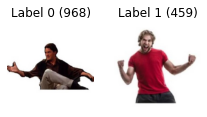

In [8]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

Normalize and grayscale

In [9]:
# converting list to array
images_np = np.array(images)

images_grayscale = np.zeros(images_np.shape[:-1])
for i in range(images_np.shape[0]): 
    images_grayscale[i] = cv2.cvtColor(images_np[i], cv2.COLOR_BGR2GRAY)

images_resize = [skimage.transform.resize(image, (244, 244), mode='constant')
            for image in images_grayscale]

# converting list to array
images_v = np.array(images_resize)
inputs = np.expand_dims(images_v, axis=3)

targets = np.array(labels)

In [10]:
#print shape
print(inputs.shape)
print(targets.shape)

#Test if normalisation was correct
# confirm the normalization
inputs = inputs/255
print('Data - Min: %.3f, Max: %.3f' % (inputs.min(), inputs.max()))

(1427, 244, 244, 1)
(1427,)
Data - Min: 0.000, Max: 1.000


In [13]:
from tensorflow.keras.models import Sequential, save_model, load_model
# Load the model
model = load_model("/content/Model_3Conv2D_loss.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 8)         0

## Setup Cross Validation using K-Fold

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Load the model
  model = load_model("/content/Model_3Conv2D_loss.h5")

  # Compile the model
  model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.RMSprop(learning_rate=0.06964726328708924),
                metrics=['acc'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size = 8,
              epochs = 100,
              verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')